# 模板

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import os
import shutil
from PIL import Image

%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 训练 fit

In [2]:
def fit(epoch, model, trainloader, testloader):
    """输入模型、输入数据(train_dl, test_dl)， 对数据输入在模型上训练，并且返回loss和acc变化"""
    correct = 0
    total = 0
    running_loss = 0
    model.train()  # 训练模式 dropout BN发挥作用
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)  # 转移到GPU
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

    # lr_decay.step()  # 学习率衰减

    epoch_loss = running_loss / len(trainloader.dataset)  # 平均loss
    epoch_acc = correct / total
    # writer.add_scalar('training loss', epoch_loss, epoch+1)  # tensorboard动态显示loss

    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()  # 预测模式 dropout BN不发挥作用
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)  # 转移到GPU
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total

    print('epoch:', epoch,
          'loss:', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss:', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

## 显示损失和准确率 show_acc

In [3]:
def show_acc(train_loss, test_loss, train_acc, test_acc):
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='train_loss')
    plt.plot(range(1, epochs+1), test_loss, label='test_loss')
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_acc, label='train_acc')
    plt.plot(range(1, epochs+1), test_acc, label='test_acc')
    plt.legend()

## 数据增强 transforms
详细见 PyTorch模型训练实用教程_余霆嵩.pdf 或 官方文档 或 源码
数据增强：扩增数据集，提高泛化能力；测试数据不需要增强；

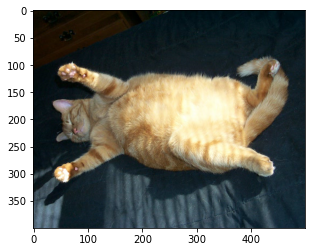

In [2]:
img = Image.open('../img/cat1.jpg')
plt.imshow(img)

In [34]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表，img[h*w*c]"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img): # 图片张量
            ax.imshow(img.numpy())
        else: # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [40]:
def apply_transforms(img, aug, num_rows=2, num_cols=4, scale=1.5):
    """在输入图像img上多次运行图像增广方法aug并显示所有结果"""
    imgs = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(imgs, num_rows, num_cols, scale=scale)

In [44]:
aug = transforms.Compose([
    transforms.RandomCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),  # 修改亮度、对比度、饱和度、色调
])

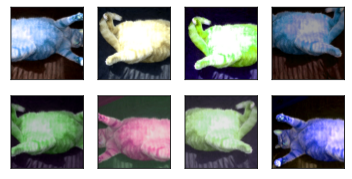

In [45]:
apply_transforms(img,aug)

### 裁剪Crop

In [ ]:
transforms.CenterCrop(224)  # 中心裁剪
transforms.RandomCrop(224)  # 随机裁剪：对整张图片敏感
transforms.RandomResizedCrop(224)  # 随机长宽比裁剪
transforms.FiveCrop(224)  # 上下左右中心裁剪
transforms.TenCrop(224)  # 上下左右中心裁剪后翻转

### 翻转和旋转 Flip and Rotation

In [ ]:
transforms.RandomHorizontalFlip(p=0.5)  # 依概率p水平翻转，即50%翻转图片，或 翻转50%的图片
transforms.RandomVerticalFlip(p=0.5)  # 依概率p垂直翻转
transforms.RandomRotation(30)  # 随机旋转30度

### 变色

In [ ]:
transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)  # 修改亮度、对比度、饱和度、色调
transforms.Grayscale()  # 转灰度图
transforms.RandomGrayscale(0.5)  # 依概率p转为灰度图

### 变换

In [ ]:
transforms.Resize((224,224))  # 重置图像分辨率(h*w)
transforms.Normalize(0, 1)  # 按通道进行标准化 h*w*c
transforms.ToTensor()  # 转为tensor，并归一化至[0-1](直接/255)
transforms.Pad(4, 0)  # 对图像进行填充，上下左右填充4个pixel，值为0；
transforms.LinearTransformation  # 线性变换，可用于白化处理
transforms.RandomAffine  # 仿射变换
transforms.ToPILImage()  # 将数据转换为PILImage
transforms.Lambda  # 用户自定义的转换

### 使数据增强更灵活
transforms.RandomChoice(transforms)， 从给定的一系列transforms中选一个进行操作
transforms.RandomApply(transforms, p=0.5)，给一个transform加上概率，依概率进行操作
transforms.RandomOrder，将transforms中的操作随机打乱

# 手写数字识别 MNIST

### 数据预处理

In [6]:
transformation = transforms.Compose([transforms.ToTensor(),])  # 转化为tensor，归一化 到0-1之间，将channel放在第一维度
train_ds = datasets.MNIST('../data/', train=True, transform=transformation, download=False)
test_ds = datasets.MNIST('../data/', train=False, transform=transformation, download=False)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256)

#### 显示图像 show_imgs
根据DataLoad显示一个批次的图像数据 前6张

In [4]:
def show_imgs(dataloader, species=None, size=3):
    """
    显示前6张图片
    :param dataloader: 数据加载器
    :param species: 种类名，顺序和dataloader一致
    :param size: 每张图片显示大小
    """
    global idx_to_species
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(6*size, 1*size))
    if species is not None:
        idx_to_species = dict((i, v) for i, v in enumerate(species))
    for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
        img = img.permute(1, 2, 0).numpy()  # 改变维度 [3, 96, 96] --> [96, 96, 3]  toTensor的逆操作
        img = (img+1)/2 # 从(-1,1)转化到(0,1)  标准化的逆操作
        plt.subplot(1, 6, i+1)
        if species is None:
            plt.title(f"{label.item()}")
        else:
            plt.title(f"{label.item()}:{idx_to_species.get(label.item())}")
        plt.imshow(img)

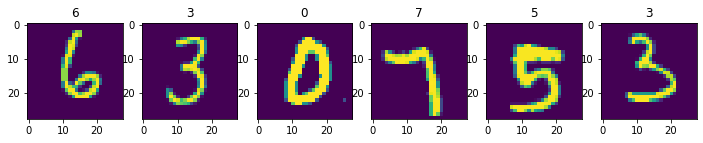

In [6]:
show_imgs(train_dl, size=2)

### 创建模型

In [15]:
# 创建全连接模型(准确率0.97)
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner_1 = nn.Linear(28*28, 120)
        self.liner_2 = nn.Linear(120, 84)
        self.liner_3 = nn.Linear(84, 10)
    def forward(self, input):
        x = input.view(-1, 28*28)  # 展平
        x = F.relu(self.liner_1(x))
        x = F.relu(self.liner_2(x))
        x = self.liner_3(x)
        return x
# 卷积模型，进一步提高准确率(0.99)
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.liner_1 = nn.Linear(16*4*4, 256)
        self.liner_2 = nn.Linear(256, 10)
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # print(x.size())    # torch.Size([64, 16, 4, 4])
        x = x.view(-1, 16*4*4)  # 展平
        x = F.relu(self.liner_1(x))
        x = self.liner_2(x)
        return x
model = Model()
model.to(device)  # 转移到GPU

### TensorBoard 可视化
1. 保存到磁盘
2. 命令行运行，在web查看
使用conda安装2.4.0版本，还要安装tensorflow(安装普通cpu就行，GPU容易出问题)

In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../mylog/mnist')

#### 图片可视化

In [9]:
images, labels = next(iter(train_dl))
img_grid = torchvision.utils.make_grid(images[:8])  # 将多张图片组成大的图片

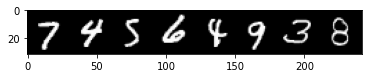

In [7]:
npimg = img_grid.permute(1, 2, 0).numpy()
plt.imshow(npimg)  # matplotlib显示

In [12]:
writer.add_image('eight_mnist_images3', img_grid)  # 保存图片

命令行查看图片
(pytorch-gpu) C:\Users\李浩然>tensorboard --logdir=D:\pro\python01\mylog\mnist
在网址 http://localhost:6006/ 查看并刷新
(以下BUG没有就跳过)
BUG:TensorFlow installation not found - running with reduced feature set. 解决 安装tensorflow(cpu版本就行)
BUG:pkg_resources.VersionConflict: google-auth... 解决 换版本，把对应文件夹中冲突文件删除

#### 模型可视化

In [16]:
writer.add_graph(model, images)  # 很强，很强

### 训练模型

epoch: 0 loss: 0.004 accuracy: 0.92 test_loss: 0.0 test_accuracy: 0.978
epoch: 1 loss: 0.001 accuracy: 0.977 test_loss: 0.0 test_accuracy: 0.981
epoch: 2 loss: 0.001 accuracy: 0.983 test_loss: 0.0 test_accuracy: 0.988
epoch: 3 loss: 0.001 accuracy: 0.987 test_loss: 0.0 test_accuracy: 0.989
epoch: 4 loss: 0.001 accuracy: 0.989 test_loss: 0.0 test_accuracy: 0.989
epoch: 5 loss: 0.0 accuracy: 0.991 test_loss: 0.0 test_accuracy: 0.989
epoch: 6 loss: 0.0 accuracy: 0.992 test_loss: 0.0 test_accuracy: 0.992
epoch: 7 loss: 0.0 accuracy: 0.994 test_loss: 0.0 test_accuracy: 0.99


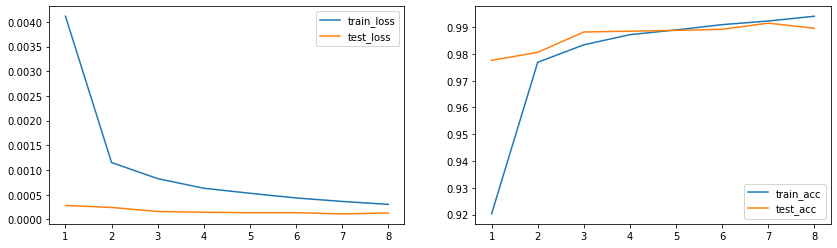

In [5]:
# 损失函数和优化器 超参数
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_acc, test_loss, test_acc = [], [], [], []
epochs = 8

# 开始训练
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

# 可视化
show_acc(train_loss, test_loss, train_acc, test_acc)

# 天气图片分类
四种天气：阴天cloudy、下雨rain、日出sunrise、阳光shine；1125张；

## 数据预处理
准备数据

In [2]:
# 创建8个目录
base_dir = r"../data/4wether"  # r防止转义
specises = ['cloudy', 'rain', 'shine', 'sunrise']
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    for train_or_test in ['train', 'test']:
        for spec in specises:
            os.mkdir(os.path.join(base_dir, train_or_test, spec))

In [3]:
# 将图片复制到新创建的文件夹；即每一种类别一个文件夹
image_dir = r"../data/weather"
for i, img in enumerate(os.listdir(image_dir)):
    for spec in specises:
        if spec in img:
            s = os.path.join(image_dir, img)
            if i%5 == 0:  # 训练接:测试集=4:1
                d = os.path.join(base_dir, 'test', spec, img)
            else:
                d = os.path.join(base_dir, 'train', spec, img)
            shutil.copy(s, d)  # 图片复制

### 加载数据 ImageFolder

In [5]:
base_dir = r"../data/4wether"  # r防止转义
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
specises = ['cloudy', 'rain', 'shine', 'sunrise']
# 对图片进行转换
transform = transforms.Compose([
                  transforms.Resize((96, 96)),  # 统一大小
                  transforms.ToTensor(),  # 转化为tensor，归一化 到0-1之间，将channel放在第一维度
                  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 将数据标准化 RGB 3个维度
])
# 创建Dataset
train_ds = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_ds = torchvision.datasets.ImageFolder(test_dir, transform=transform)
print(train_ds.classes, train_ds.class_to_idx)  # 有哪些文件夹就有哪些类
# 创建DataLoad
BATCHSIZE = 16
train_dl = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE)

['cloudy', 'rain', 'shine', 'sunrise'] {'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}


### 自定义DataSet类
torchvision.datasets.ImageFolder缺点是必须放在对应文件夹中

In [20]:
from PIL import Image
import glob
imgs_path = glob.glob(r"..\data\4wether\*\*\*.jpg")  # r防止转义 所有图片路径
np.random.seed(10)
index = np.random.permutation(len(imgs_path))  # 返回乱序索引
imgs_path = np.array(imgs_path)[index]  # 随机打乱
s = int(len(imgs_path)*0.8)  # 训练集:测试集=4:1
# 可根据路径切割字符串，然后np.unique()，然后label_to_index 或 index_to_label
species = ['cloudy', 'rain', 'shine', 'sunrise']

class Mydataset(Dataset):
    def __init__(self, imgs_path):
        labels = []
        for img in imgs_path:
            img = img.replace("train", "") # 切掉train，否则有rain导致图片标签对应不上；找了2H BUG，艹
            for i, c in enumerate(species):
                if c in img:
                    labels.append(i)
        transform = transforms.Compose([
                          transforms.Resize((96, 96)),  # 统一大小
                          transforms.ToTensor(),  # 转化为tensor，归一化 到0-1之间，将channel放在第一维度
                          transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 将数据标准化 RGB 3个维度
        ])
        self.imgs = imgs_path
        self.labels = labels
        self.transforms = transform

    def __getitem__(self, index):
        """实现切片功能，支持下标操作dataset[index]"""
        img = self.imgs[index]  # 路径
        label = self.labels[index]
        img = Image.open(img).convert("RGB")  # 读取图片，统一为三维RGB
        img = self.transforms(img)   # 转换
        return img, label

    def __len__(self):
        """返回元素个数"""
        return len(self.imgs)

BATCHSIZE = 8
train_dl = DataLoader(Mydataset(imgs_path[:s]), batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(Mydataset(imgs_path[s:]), batch_size=BATCHSIZE)

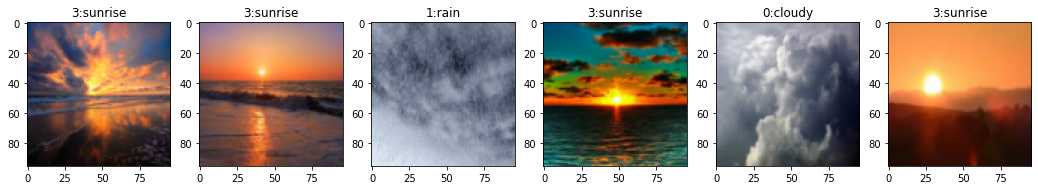

In [21]:
show_imgs(train_dl, species)

## 创建模型

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.3)  # 抑制过拟合 一般添加在后半部分
        self.drop2d = nn.Dropout2d(0.3)

        self.linear1 = nn.Linear(64 * 10 * 10, 1024)
        self.bn_linear1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(1024, 256)
        self.bn_linear2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2d(self.pool(F.relu(self.bn3(self.conv3(x)))))
        # print(x.size())
        x = x.view(-1, 64*10*10)
        x = self.drop(F.relu(self.bn_linear1(self.linear1(x))))
        x = self.drop(F.relu(self.bn_linear2(self.linear2(x))))
        x = self.linear3(x)
        return x

model = Net()
MODELPATH = "../model/4weather.pth"
model.load_state_dict(torch.load(MODELPATH))  # 加载已训练的参数
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.3, inplace=False)
  (drop2d): Dropout2d(p=0.3, inplace=False)
  (linear1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_linear1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_linear2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=256, out_featur

### 学习率衰减 lr_scheduler
一般在训练初期给予较大的学习率，随着训练的进行，学习率逐渐减小。
定义学习率衰减策略(可以自己编写)lr_decay=lr_scheduler.XXX，并在fit中lr_decay.step()

[等间隔衰减] lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)  # 每隔5个epoch，lr = lr*gamma
[按设定的间隔衰减] lr_scheduler.MultiStepLR(optim, milestones=[5, 10, 20], gamma=0.1)  # 隔5个epoch、隔10个、隔20个，调整学习率
按指数衰减 lr_scheduler.ExponentialLR(optim, gamma=0.1)  # 每个epoch都衰减，lr = lr*(gamma**epoch)
以余弦函数为周期，并在每个周期最大值时重新设置学习率 lr_scheduler.CosineAnnealingLR
当某指标不再变化时调整学习率 lr_scheduler.ReduceLROnPlateau
为不同参数组设定不同学习率调整策略 lr_scheduler.LambdaLR  # lr = base_lr * lmbda(self.last_epoch)

In [ ]:
from torch.optim import lr_scheduler
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)  # 每隔5个epoch，lr = lr*gamma

## 训练模型

epoch: 0 loss: 0.016 accuracy: 0.91 test_loss: 0.018 test_accuracy: 0.916
epoch: 1 loss: 0.015 accuracy: 0.911 test_loss: 0.018 test_accuracy: 0.92
epoch: 2 loss: 0.014 accuracy: 0.93 test_loss: 0.028 test_accuracy: 0.862
epoch: 3 loss: 0.015 accuracy: 0.92 test_loss: 0.016 test_accuracy: 0.92
epoch: 4 loss: 0.017 accuracy: 0.907 test_loss: 0.017 test_accuracy: 0.924


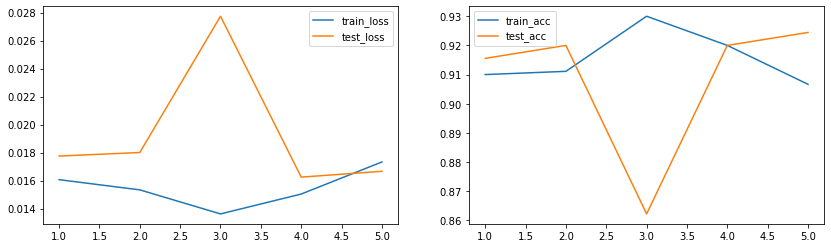

In [11]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = lr_scheduler.StepLR(optim, step_size=5, gamma=0.2)  # 学习率衰减：每隔5步，将学习率*gamma
train_loss, train_acc, test_loss, test_acc = [], [], [], []
epochs = 10

# 开始训练
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

# 可视化
show_acc(train_loss, test_loss, train_acc, test_acc)

### 保存最好模型参数 model.state_dict

In [9]:
import copy
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# 开始训练
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    if epoch_test_acc > best_acc:  # 保存最好模型参数
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

MODELPATH = "../model/4weather.pth"
torch.save(best_model_wts, MODELPATH)  # 保存了模型中的可训练参数

epoch: 0 loss: 0.021 accuracy: 0.884 test_loss: 0.021 test_accuracy: 0.898
epoch: 1 loss: 0.019 accuracy: 0.888 test_loss: 0.021 test_accuracy: 0.907
epoch: 2 loss: 0.017 accuracy: 0.901 test_loss: 0.033 test_accuracy: 0.827
epoch: 3 loss: 0.019 accuracy: 0.889 test_loss: 0.019 test_accuracy: 0.92
epoch: 4 loss: 0.016 accuracy: 0.924 test_loss: 0.018 test_accuracy: 0.916


# 现代卷积神经网络

## LeNet
没有内置，已被淘汰，但是最早的卷积模型之一

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride

            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

## AlexNet 深度卷积网络

In [ ]:
models.AlexNet()  # 点进去就能看到模型

## VGG 使用块的网络
make_layers() 用来创建vgg模型的卷积层，用features表示
卷积基是features，用来提取特征，最后是classifier分类器
D表示vgg16，里面有13个卷积层，再加上最后的3层全连接层，正好16层；E表示vgg19;

In [ ]:
models.vgg16()

## NiN 网络中的网络

In [ ]:
class NiN(nn.Module):
    def nin_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )

    def __init__(self, num_labels):
        super(NiN, self).__init__()
        self.net = nn.Sequential(
            self.nin_block(3, 96, kernel_size=11, stride=4, padding=2),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=3, stride=2),
            self.nin_block(96, 256, kernel_size=5, stride=1, padding=2),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=3, stride=2),
            self.nin_block(256, 384, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=3, stride=2),
            self.nin_block(384, num_labels, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.init_weight()

    def forward(self,x):
        return self.net(x)

    def init_weight(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)

    def test_output_shape(self):
        test_img = torch.rand(size=(1, 3, 227, 227), dtype=torch.float32)
        for layer in self.net:
            test_img = layer(test_img)
            print(layer.__class__.__name__, 'output shape: \t', test_img.shape)

## GoogLeNet 含并行连接的网络
Inception块

In [ ]:
models.googlenet()

In [ ]:
models.inception_v3()

## ResNet 残差网络 预训练模型

In [ ]:
# 使用预训练模型(已经在imageNet上训练好了) C:\Users\李浩然\.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
model = models.resnet101(pretrained=True)
for param in model.parameters():  # 全部参数冻结
    param.requires_grad = False  # 微调可以解开
model.fc = nn.Linear(model.fc.in_features, 4)  #替换最后一层 默认可训练
torch.cuda.empty_cache()  # 清空一下，否则会爆显存
model.to(device)  # 放在最后

## DenseNet 稠密连接网络
C:\Users\李浩然\.cache\torch\hub\checkpoints\densenet121-a639ec97.pth

In [26]:
models.densenet121()